In [1]:
import torch
from torchvision import models
import torch.nn as nn
from torch.nn.functional import relu

In [2]:
class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        #ENCODE PART
        ## input = 572, 572,3
        self.el1 = nn.Conv2d(3, 64, 3, padding= 1) ## 570,570,64
        self.el2 = nn.Conv2d(64, 64, 3, padding = 1) # 568, 568, 64
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 284, 284, 64

        self.el3 = nn.Conv2d(64, 128, 3, padding = 1) #282, 282, 128
        self.el4 = nn.Conv2d(128, 128, 3, padding = 1) #280, 280, 128
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 140, 140, 128

        self.el5 = nn.Conv2d(128, 256, 3, padding = 1) #138, 138, 256
        self.el6 = nn.Conv2d(256, 256, 3, padding = 1) #136, 136, 256
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 68, 68, 256

        self.el7 = nn.Conv2d(256, 512, 3, padding = 1) #66, 66, 512
        self.el8 = nn.Conv2d(512, 512, 3, padding = 1) #64, 64, 512
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 32, 32, 512

        self.el9 = nn.Conv2d(512, 1024, 3, padding = 1) #30, 30, 1024
        self.el10 = nn.Conv2d(1024, 1024, 3, padding = 1) #28, 28, 1024


        #DECODER PART
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride = 2) # 56, 56, 512
        self.dl1 = nn.Conv2d(1024, 512, 3, padding = 1)
        self.dl2 = nn.Conv2d(512, 512, 3, padding = 1)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride = 2) # 104, 104, 256
        self.dl3 = nn.Conv2d(512, 256, 3, padding = 1)
        self.dl4 = nn.Conv2d(256, 256, 3, padding = 1)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride = 2) # 200,200, 128
        self.dl5 = nn.Conv2d(256, 128, 3, padding = 1)
        self.dl6 = nn.Conv2d(128, 128, 3, padding = 1)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride = 2) # 392,392,64
        self.dl7 = nn.Conv2d(128, 64, 3, padding = 1)
        self.dl8 = nn.Conv2d(64, 64, 3, padding = 1)

        #OutputLayer
        self.out = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        #ENCODE PART
        xe11 = relu(self.el1(x))
        xe12 = relu(self.el2(xe11))
        pool1 = self.pool1(xe12)

        xe21 = relu(self.el3(pool1))
        xe22 = relu(self.el4(xe21))
        pool2 = self.pool2(xe22)

        xe31 = relu(self.el5(pool2))
        xe32 = relu(self.el6(xe31))
        pool3 = self.pool3(xe32)

        xe41 = relu(self.el7(pool3))
        xe42 = relu(self.el8(xe41))
        pool4 = self.pool4(xe42)

        xe51 = relu(self.el9(pool4))
        xe52 = relu(self.el10(xe51))

        xu1 = self.up1(xe52)
        xu1 = torch.cat((xu1, xe42), dim = 1) #skip connection
        xu11 = relu(self.dl1(xu1))
        xu12 = relu(self.dl2(xu11))

        xu2 = self.up2(xu12)
        xu2 = torch.cat((xu2, xe32), dim = 1) #skip connection
        xu21 = relu(self.dl3(xu2))
        xu22 = relu(self.dl4(xu21))

        xu3 = self.up3(xu22)
        xu3 = torch.cat((xu3, xe22), dim = 1) #skip connection
        xu31 = relu(self.dl5(xu3))
        xu32 = relu(self.dl6(xu31))

        xu4 = self.up4(xu32)
        xu4 = torch.cat((xu4, xe12), dim = 1) #skip connection
        xu41 = relu(self.dl7(xu4))
        xu42 = relu(self.dl8(xu41))

        out = self.out(xu42)
        return out

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
from functools import reduce
import itertools
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from collections import defaultdict
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy


def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])

    X = np.asarray(x) * 255
    X = X.repeat(3, axis=1).transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)

    return X, Y


def generate_img_and_mask(height, width):
    shape = (height, width)

    triangle_location = get_random_location(*shape)
    circle_location1 = get_random_location(*shape, zoom=0.7)
    circle_location2 = get_random_location(*shape, zoom=0.5)
    mesh_location = get_random_location(*shape)
    square_location = get_random_location(*shape, zoom=0.8)
    plus_location = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    arr = add_mesh_square(arr, *mesh_location)
    arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
         add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_mesh_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks


def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr


def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))


def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array


def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))


def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr


def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr


def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr


def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)

    return (x, y, size)


def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])


def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))


def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()


def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)


def generate_images_and_masks_then_plot():
    # Generate some random images
    input_images, target_masks = generate_random_data(192, 192, count=3)

    for x in [input_images, target_masks]:
        print(x.shape)
        print(x.min(), x.max())

    # Change channel-order and make 3 channels for matplot
    input_images_rgb = [x.astype(np.uint8) for x in input_images]

    # Map each channel (i.e. class) to each color
    target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

    # Left: Input image (black and white), Right: Target mask (6ch)
    plot_side_by_side([input_images_rgb, target_masks_rgb])


def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp


class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = generate_random_data(192, 192, count=count)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]


def get_data_loaders():
    # use the same transformations for train/val in this example
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])

    train_set = SimDataset(100, transform = trans)
    val_set = SimDataset(20, transform = trans)

    image_datasets = {
        'train': train_set, 'val': val_set
    }

    batch_size = 25

    dataloaders = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
        'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
    }

    return dataloaders


def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()


def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss


def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


def train_model(model, optimizer, scheduler, num_epochs=25):
    dataloaders = get_data_loaders()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        for param_group in optimizer.param_groups:
                            print("LR", param_group['lr'])


                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def run(UNet):
    num_class = 6
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = UNet(num_class).to(device)

    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

    model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

    model.eval()  # Set model to the evaluation mode

    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # imagenet
    ])
    # # Create another simulation dataset for test
    test_dataset = SimDataset(3, transform = trans)
    test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

    # Get the first batch
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Predict
    pred = model(inputs)
    # The loss functions include the sigmoid function.
    pred = F.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    print(pred.shape)

    # Change channel-order and make 3 channels for matplot
    input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

    # Map each channel (i.e. class) to each color
    target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
    pred_rgb = [masks_to_colorimg(x) for x in pred]

    plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

Epoch 0/59
----------
LR 0.0001
LR 0.0001
LR 0.0001
LR 0.0001
train: bce: 0.681586, dice: 0.990390, loss: 0.835987
val: bce: 0.671851, dice: 0.990965, loss: 0.831408
saving best model
0m 4s
Epoch 1/59
----------
LR 0.0001
LR 0.0001
LR 0.0001
LR 0.0001
train: bce: 0.665406, dice: 0.990415, loss: 0.827910
val: bce: 0.652592, dice: 0.991014, loss: 0.821803
saving best model
0m 3s
Epoch 2/59
----------
LR 0.0001
LR 0.0001
LR 0.0001
LR 0.0001
train: bce: 0.641527, dice: 0.990487, loss: 0.816007
val: bce: 0.619375, dice: 0.991125, loss: 0.805250
saving best model
0m 3s
Epoch 3/59
----------
LR 0.0001
LR 0.0001
LR 0.0001
LR 0.0001
train: bce: 0.600281, dice: 0.990671, loss: 0.795476
val: bce: 0.559845, dice: 0.991385, loss: 0.775615
saving best model
0m 3s
Epoch 4/59
----------
LR 0.0001
LR 0.0001
LR 0.0001
LR 0.0001
train: bce: 0.520913, dice: 0.991117, loss: 0.756015
val: bce: 0.433350, dice: 0.992167, loss: 0.712758
saving best model
0m 3s
Epoch 5/59
----------
LR 0.0001
LR 0.0001
LR 0.000

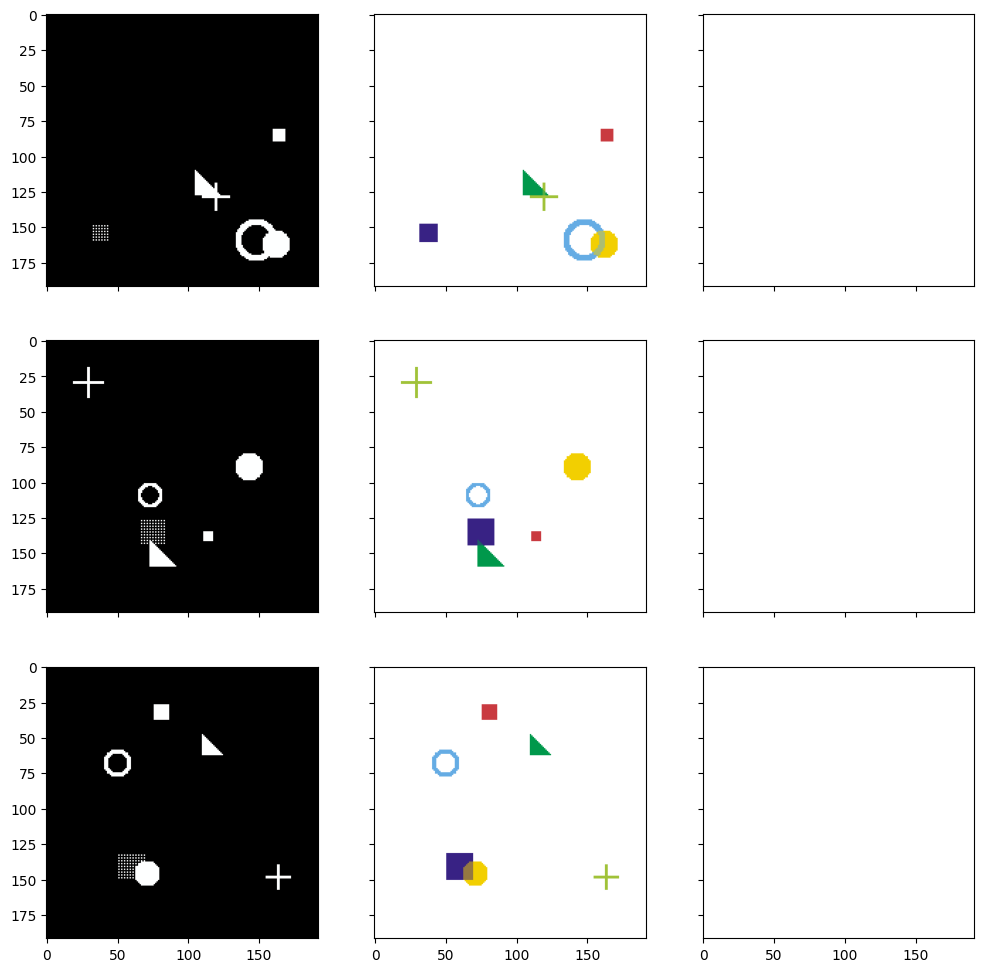

In [4]:
import test
run(UNet)